 Example of how to generate sky spectra or magnitudes. Follow install instructions for `rubin_sim` at https://github.com/lsst/rubin_sim
 
 The sky brightness model uses the ESO sky model with components of scattered starlight, scattered moonlight, zodiacal light, emission from the lower atmosphere, and airglow. We have added a simple model for scattered twilight. We have pre-computed spectra and LSST magnitudes for a range of values for each of these parameters.
 
This all assumes the atmosphere for your observatory is similar to the Rubin site, that is, while you can input a different observatory altitude, the library we have built won't make proper adjustments to things like the airglow.

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.skybrightness import SkyModel
from rubin_sim.utils import Site    

## To get a sky spectrum:

In [2]:
# configure your Site, will default to Rubin if you use Site()
site = Site(latitude=33.35,longitude=116.85,height=1706)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/utils/site.py:176: UserWarning: The following attributes of your Site were None:
temperature
pressure
humidity
lapse_rate
If you want these to just default to LSST values,
instantiate your Site with name='LSST'
  warnings.warn(msg)


In [3]:
sky_model = SkyModel(observatory=site)

In [4]:
# Set the positions and time we want. Will probably throw an error if you ask for something
# that isn't visible. lon and lat can be arrays if you want lots of points on the sky.
sky_model.set_ra_dec_mjd(lon=270., lat=30., mjd=61200.75, degrees=True)

wave, spec = sky_model.return_wave_spec()


In [5]:
wave, spec

(array([ 300. ,  300.2,  300.4, ..., 2499.6, 2499.8, 2500. ]),
 array([[5.33597544e-18, 5.48201154e-18, 5.72807619e-18, ...,
         1.01005704e-14, 8.47402655e-15, 6.41368566e-15]]))

Text(0.5, 1.0, 'sky from RA,dec MJD')

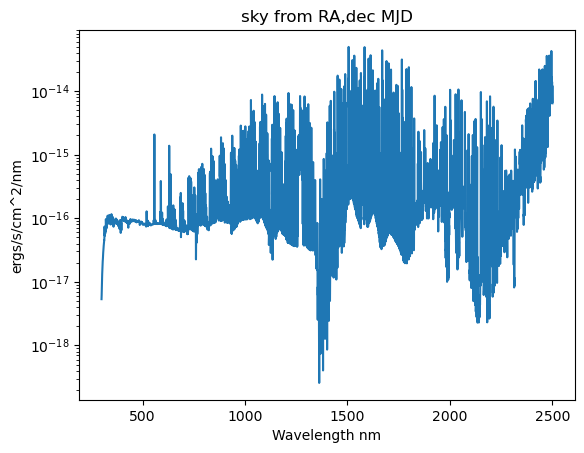

In [6]:
plt.semilogy(wave, spec[0])
plt.xlabel('Wavelength nm')
plt.ylabel('ergs/s/cm^2/nm')
plt.title('sky from RA,dec MJD')

In [7]:
# can be nice to see what values have been computed to come up with this
print(sky_model.get_computed_vals())
computed_vals = sky_model.get_computed_vals()

{'ra': array([4.71238898]), 'dec': array([0.52359878]), 'alts': array([1.34114514]), 'azs': array([4.52556495]), 'airmass': array([1.02696201]), 'solar_flux': 130.0, 'moon_phase': 40.9126411683738, 'moon_az': 1.6111336782894203, 'moon_alt': 0.19049268240746264, 'sun_alt': -0.48989985000279823, 'sun_az': 0.4939163483348462, 'az_rel_sun': array([4.0316486]), 'moon_sun_sep': 1.2853085293351847, 'az_rel_moon': array([2.91443127]), 'eclip_lon': array([4.71222235]), 'eclip_lat': array([0.93267675]), 'moon_ra': 0.06001212550762677, 'moon_dec': 0.07751557622561957, 'sun_ra': 1.3534043745582014, 'sun_dec': 0.40041236637201805, 'sun_eclip_lon': 1.3708434404492906}


Text(0.5, 1.0, 'sky from azimuth,altitude MJD')

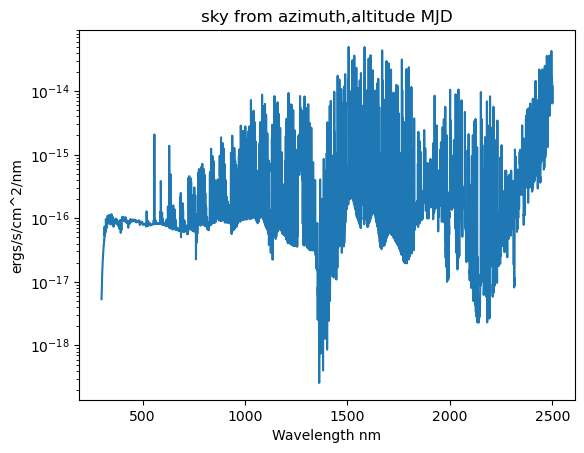

In [8]:
# let's check that things come out the same if we specify alt,az coordinates
sky_model.set_ra_dec_mjd(lon=computed_vals['azs'], lat=computed_vals['alts'],
                         mjd=61200.75, degrees=False, az_alt=True)
wave, spec = sky_model.return_wave_spec()
plt.semilogy(wave, spec[0])
plt.xlabel('Wavelength nm')
plt.ylabel('ergs/s/cm^2/nm')
plt.title('sky from azimuth,altitude MJD')

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness/interp_components.py:602: UserWarning: Extrapolating twilight beyond a sun altitude of -11 degrees
  warnings.warn("Extrapolating twilight beyond a sun altitude of -11 degrees")


Text(0.5, 1.0, 'Extrapolating to sun alt = -7.77 deg, things break down')

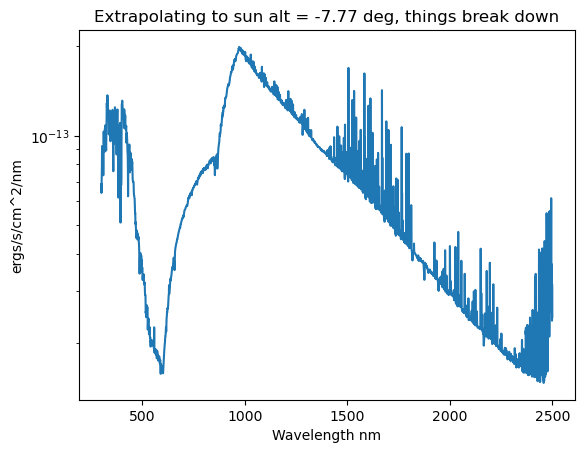

In [9]:
# Note, you can ask it to extrapolate beyond what it was built for. Should throw a
# warning (or sometimes just crashes)
sky_model.set_ra_dec_mjd(lon=270., lat=30., mjd=61200.5, degrees=True)
computed_vals = sky_model.get_computed_vals()
wave, spec = sky_model.return_wave_spec()
plt.semilogy(wave, spec[0])
plt.xlabel('Wavelength nm')
plt.ylabel('ergs/s/cm^2/nm')
plt.title('Extrapolating to sun alt = %.2f deg, things break down' % np.degrees(computed_vals['sun_alt']))

## getting magnitudes

In [10]:
# Run with mags=True to use pre-computed LSST filter magnitudes rather then full spectra
site = Site(latitude=33.35,longitude=116.85,height=1706)
sky_model = SkyModel(observatory=site, mags=True)

In [11]:
sky_model.set_ra_dec_mjd(lon=270., lat=30., mjd=61200.75, degrees=True)


/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness/sky_model.py:685: UserWarning: Wavelength arrays of components do not match.
  warnings.warn("Wavelength arrays of components do not match.")


In [12]:
mags = sky_model.return_mags()  # Should be mags/sq arcsec
print(mags)

{'u': array([22.43881943]), 'g': array([21.82168989]), 'r': array([21.12938197]), 'i': array([20.36708572]), 'z': array([19.46170737]), 'y': array([18.62676026])}


In [13]:
from rubin_sim.utils import hpid2_ra_dec
import healpy as hp
# can be fun to run on a HEALpix grid to get the full sky
nside = 32
ra, dec = hpid2_ra_dec(nside, np.arange(hp.nside2npix(nside)))

sky_model.set_ra_dec_mjd(lon=ra, lat=dec, mjd=61200.75, degrees=True)

mags = sky_model.return_mags()

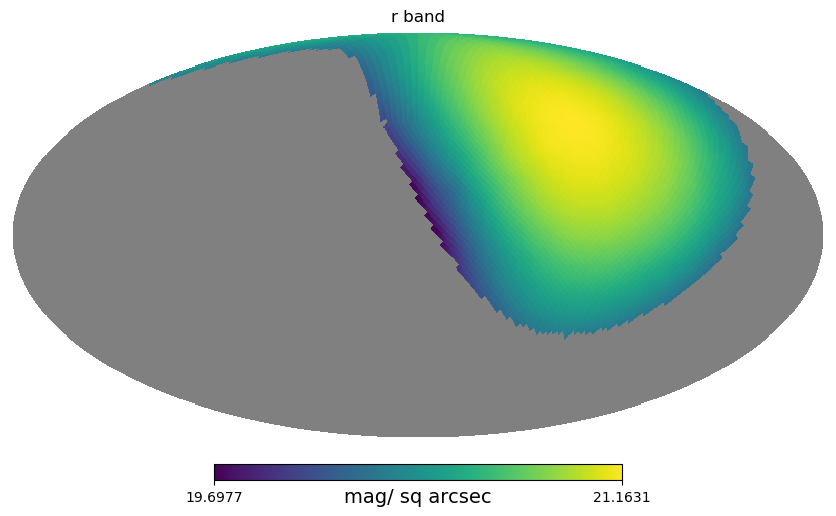

In [14]:
hp.mollview(mags['r'], unit='mag/ sq arcsec', title='r band')

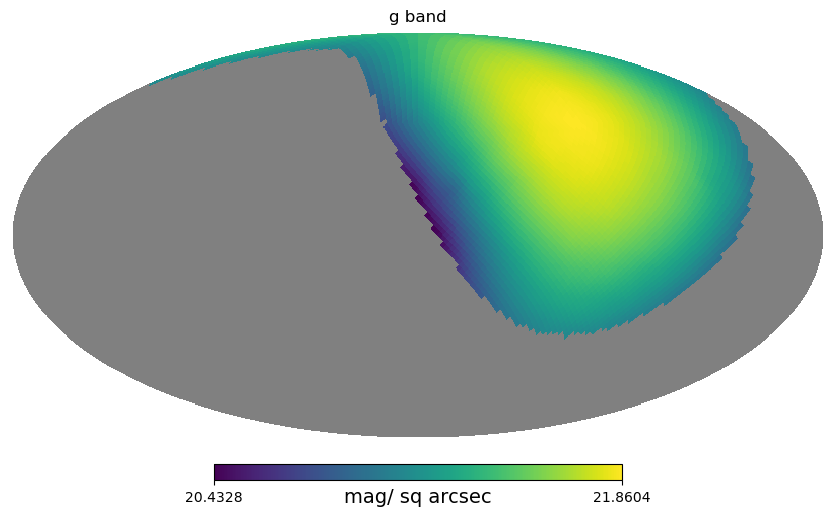

In [15]:
hp.mollview(mags['g'], unit='mag/ sq arcsec', title='g band')

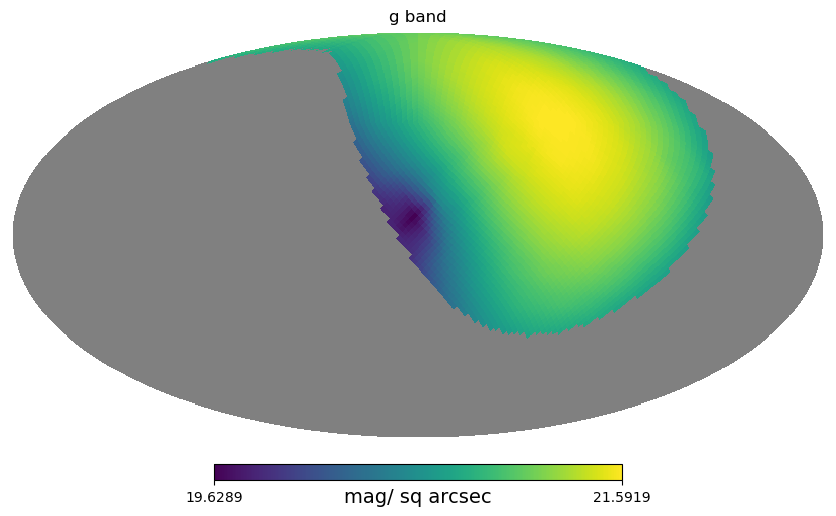

In [16]:
# can advance to later in the night
sky_model.set_ra_dec_mjd(lon=ra, lat=dec, mjd=61200.80, degrees=True)
mags = sky_model.return_mags()
hp.mollview(mags['g'], unit='mag/ sq arcsec', title='g band')